#IMPORTS AND SETUP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Libraries imported!")

✅ Libraries imported!


DATA LOADING

In [2]:
# Upload salaries.csv to your Colab session first
df = pd.read_csv('salaries.csv')
print(f"✅ Dataset loaded! Shape: {df.shape}")

# Remove duplicates
initial_rows = df.shape[0]
df.drop_duplicates(inplace=True)
print(f"🧹 Removed {initial_rows - df.shape[0]} duplicates")

✅ Dataset loaded! Shape: (16494, 11)
🧹 Removed 6401 duplicates


#FEATURE ENGINEERING

In [3]:
print("🔧 Creating advanced features...")

# 1. Remote work type
if 'remote_ratio' in df.columns:
    df['remote_work_type'] = df['remote_ratio'].apply(
        lambda x: 'Remote' if x == 1 else ('Hybrid' if x == 0.5 else 'On-site')
    )

# 2. Advanced job title categorization
def categorize_job_title_advanced(title):
    title = str(title).lower()

    if any(word in title for word in ['research scientist', 'research engineer', 'ai researcher']):
        return 'Research_Scientist'
    elif any(word in title for word in ['machine learning engineer', 'ml engineer', 'ml/ai engineer']):
        return 'ML_Engineer'
    elif any(word in title for word in ['ai engineer', 'artificial intelligence engineer']):
        return 'AI_Engineer'
    elif any(word in title for word in ['data scientist', 'senior data scientist']):
        return 'Data_Scientist'
    elif any(word in title for word in ['software engineer', 'backend engineer']):
        return 'Software_Engineer'
    elif any(word in title for word in ['data engineer', 'etl engineer']):
        return 'Data_Engineer'
    elif any(word in title for word in ['data analyst', 'business analyst']):
        return 'Data_Analyst'
    elif any(word in title for word in ['manager', 'head of', 'director', 'lead']):
        return 'Management'
    elif any(word in title for word in ['nlp', 'natural language', 'computer vision']):
        return 'Specialized_ML'
    else:
        return 'Other'

df['job_title_category'] = df['job_title'].apply(categorize_job_title_advanced)

# 3. Country extraction
def extract_country(location):
    if pd.isna(location):
        return 'Unknown'

    location = str(location).strip()
    country_mapping = {
        'US': 'United_States', 'CA': 'Canada', 'GB': 'United_Kingdom', 'UK': 'United_Kingdom',
        'AU': 'Australia', 'DE': 'Germany', 'FR': 'France', 'NL': 'Netherlands',
        'IN': 'India', 'BR': 'Brazil', 'ES': 'Spain', 'IT': 'Italy',
        'SE': 'Sweden', 'CH': 'Switzerland', 'JP': 'Japan', 'SG': 'Singapore'
    }

    for code, country in country_mapping.items():
        if location == code or location == country:
            return country

    return 'Other_Countries'

df['country'] = df['company_location'].apply(extract_country)

# 4. Salary transformations
df['salary_log'] = np.log1p(df['salary_in_usd'])
df['salary_sqrt'] = np.sqrt(df['salary_in_usd'])

# 5. Ordinal encodings
experience_mapping = {'EN': 1, 'MI': 2, 'SE': 3, 'EX': 4}
size_mapping = {'S': 1, 'M': 2, 'L': 3}
employment_mapping = {'FT': 1, 'PT': 0.5, 'CT': 0.8, 'FL': 0.7}

df['experience_level_encoded'] = df['experience_level'].map(experience_mapping)
df['company_size_encoded'] = df['company_size'].map(size_mapping)
df['employment_type_encoded'] = df['employment_type'].map(employment_mapping)

# 6. Interaction features
df['exp_size_interaction'] = df['experience_level_encoded'] * df['company_size_encoded']
df['exp_remote_interaction'] = df['experience_level_encoded'] * (df['remote_ratio'] if 'remote_ratio' in df.columns else 0)
df['size_remote_interaction'] = df['company_size_encoded'] * (df['remote_ratio'] if 'remote_ratio' in df.columns else 0)

# 7. Job title complexity
df['job_title_complexity'] = df['job_title'].str.split().str.len()

# 8. Location diversity
location_counts = df.groupby('job_title')['company_location'].nunique()
df['location_diversity'] = df['job_title'].map(location_counts)

# 9. Salary statistics by groups
job_title_stats = df.groupby('job_title')['salary_in_usd'].agg(['mean', 'std', 'count']).reset_index()
job_title_stats.columns = ['job_title', 'job_title_mean_salary', 'job_title_std_salary', 'job_title_count']
df = df.merge(job_title_stats, on='job_title', how='left')

exp_stats = df.groupby('experience_level')['salary_in_usd'].agg(['mean', 'std']).reset_index()
exp_stats.columns = ['experience_level', 'exp_level_mean_salary', 'exp_level_std_salary']
df = df.merge(exp_stats, on='experience_level', how='left')

size_stats = df.groupby('company_size')['salary_in_usd'].agg(['mean', 'std']).reset_index()
size_stats.columns = ['company_size', 'company_size_mean_salary', 'company_size_std_salary']
df = df.merge(size_stats, on='company_size', how='left')

# 10. Salary percentiles
def get_salary_percentile(row):
    job_title_data = df[df['job_title'] == row['job_title']]['salary_in_usd']
    if len(job_title_data) > 1:
        return (job_title_data < row['salary_in_usd']).mean()
    return 0.5

df['salary_percentile_by_title'] = df.apply(get_salary_percentile, axis=1)

# 11. Premium features
remote_stats = df.groupby('remote_work_type')['salary_in_usd'].mean()
df['remote_premium'] = df['remote_work_type'].map(remote_stats)

country_stats = df.groupby('country')['salary_in_usd'].mean()
df['country_salary_premium'] = df['country'].map(country_stats)

print(f"✅ Created {len(df.columns)} total features!")

🔧 Creating advanced features...
✅ Created 34 total features!


FEATURE SELECTION AND PREPROCESSING

In [5]:
print("�� Preparing features for modeling...")

# Drop original columns
columns_to_drop = [
    'salary', 'salary_currency', 'remote_ratio',
    'job_title', 'company_location', 'experience_level', 'company_size', 'employment_type',
    'remote_work_type'
]

feature_columns = [col for col in df.columns if col not in columns_to_drop + ['salary_in_usd']]
X = df[feature_columns]
y = df['salary_in_usd']

print(f"Feature matrix shape: {X.shape}")

# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Categorical columns: {categorical_columns}")

# Apply one-hot encoding to categorical columns
if categorical_columns:
    X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=True)
    print(f"After encoding: {X_encoded.shape}")
else:
    X_encoded = X.copy()

# Handle missing values in numeric columns only
X_encoded = X_encoded.fillna(X_encoded.median())

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Scale features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Data prepared!")
print(f"Final feature count: {X_encoded.shape[1]}")

�� Preparing features for modeling...
Feature matrix shape: (10093, 24)
Categorical columns: ['employee_residence', 'job_title_category', 'country']
After encoding: (10093, 132)
✅ Data prepared!
Final feature count: 132


FEATURE IMPORTANCE

📊 Analyzing feature importance...

🔝 Top 10 Most Important Features:
                            feature  importance
2                       salary_sqrt    0.527961
1                        salary_log    0.471854
11            job_title_mean_salary    0.000047
111  job_title_category_ML_Engineer    0.000038
13                  job_title_count    0.000035
12             job_title_std_salary    0.000021
10               location_diversity    0.000008
18       salary_percentile_by_title    0.000008
3          experience_level_encoded    0.000005
6              exp_size_interaction    0.000004


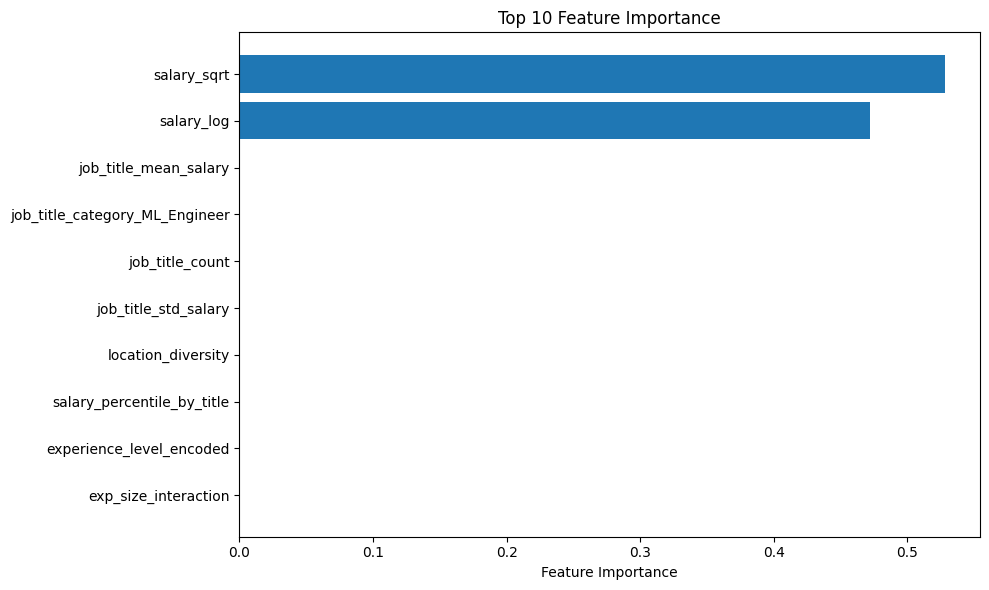

In [6]:
print("📊 Analyzing feature importance...")

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔝 Top 10 Most Important Features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#MODEL TRAINING

In [7]:
print("🤖 Training multiple models...")

models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    print(f"Training {name}...")

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {'MAE': mae, 'RMSE': rmse, 'R²': r2}
    print(f"  {name} - MAE: ${mae:,.2f}, RMSE: ${rmse:,.2f}, R²: {r2:.4f}")

# Display results
results_df = pd.DataFrame(results).T
print("\n📋 Model Performance:")
print(results_df.round(4))

🤖 Training multiple models...
Training Random Forest...
  Random Forest - MAE: $152.29, RMSE: $2,100.27, R²: 0.9993
Training XGBoost...
  XGBoost - MAE: $1,023.84, RMSE: $8,609.75, R²: 0.9874
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1192
[LightGBM] [Info] Number of data points in the train set: 8074, number of used features: 49
[LightGBM] [Info] Start training from score 146841.711791
  LightGBM - MAE: $1,367.52, RMSE: $11,841.46, R²: 0.9762

📋 Model Performance:
                     MAE        RMSE      R²
Random Forest   152.2857   2100.2702  0.9993
XGBoost        1023.8419   8609.7480  0.9874
LightGBM       1367.5196  11841.4633  0.9762


DEEP LEARNING MODEL

In [8]:

print("🧠 Training Deep Learning model...")

def create_advanced_nn(input_dim):
    model = keras.Sequential([
        layers.Dense(256, activation='relu', input_dim=input_dim),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

dl_model = create_advanced_nn(X_train_scaled.shape[1])

early_stopping = EarlyStopping(patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=10, min_lr=1e-6)

history = dl_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

y_pred_dl = dl_model.predict(X_test_scaled).flatten()

dl_mae = mean_absolute_error(y_test, y_pred_dl)
dl_rmse = np.sqrt(mean_squared_error(y_test, y_pred_dl))
dl_r2 = r2_score(y_test, y_pred_dl)

print(f"\n🧠 Deep Learning Results:")
print(f"MAE: ${dl_mae:,.2f}")
print(f"RMSE: ${dl_rmse:,.2f}")
print(f"R²: {dl_r2:.4f}")

🧠 Training Deep Learning model...
Epoch 1/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 26458587136.0000 - mae: 146028.5625 - val_loss: 28638832640.0000 - val_mae: 151108.1562 - learning_rate: 0.0010
Epoch 2/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 26455461888.0000 - mae: 146023.7812 - val_loss: 28634003456.0000 - val_mae: 151100.4062 - learning_rate: 0.0010
Epoch 3/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 26450264064.0000 - mae: 146013.7031 - val_loss: 28625895424.0000 - val_mae: 151086.4062 - learning_rate: 0.0010
Epoch 4/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 26442510336.0000 - mae: 145997.5625 - val_loss: 28616187904.0000 - val_mae: 151066.6719 - learning_rate: 0.0010
Epoch 5/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 26432489472.0000 - mae: 145975.9062 - val_loss: 28601016320.0000 - val_mae: 151033.3906 - learning_rate: 0.0010
Epoch 6/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 26420469760.0000 - mae: 145949.0469 - va

#Model Evaluation

📈 Comparing all models...
🏆 Best Model: Random Forest


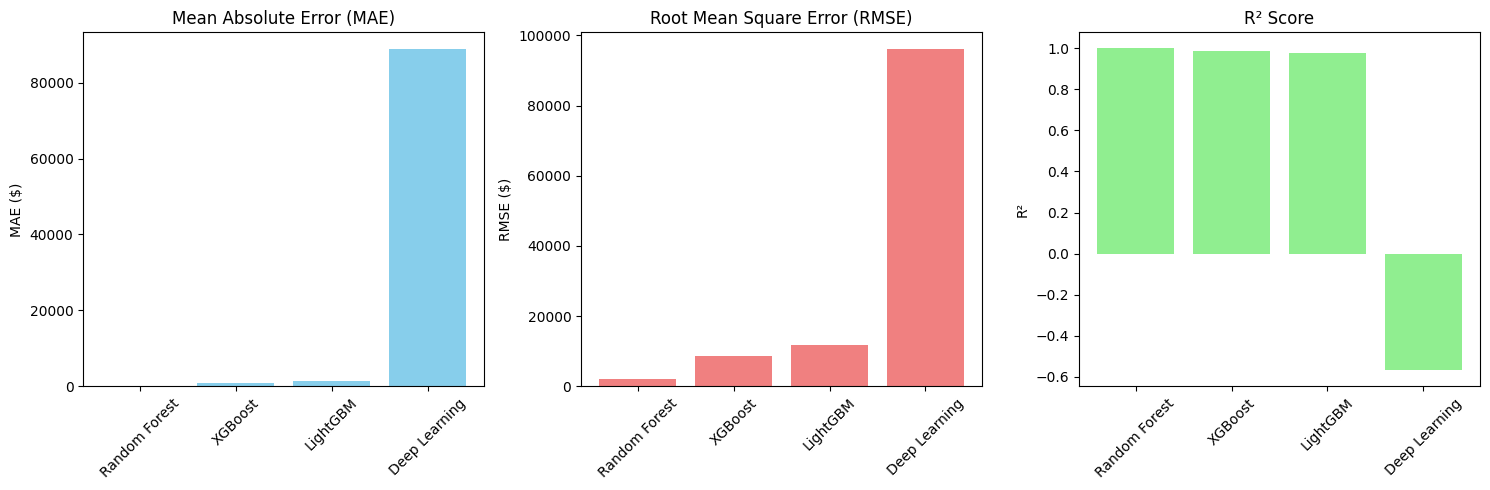

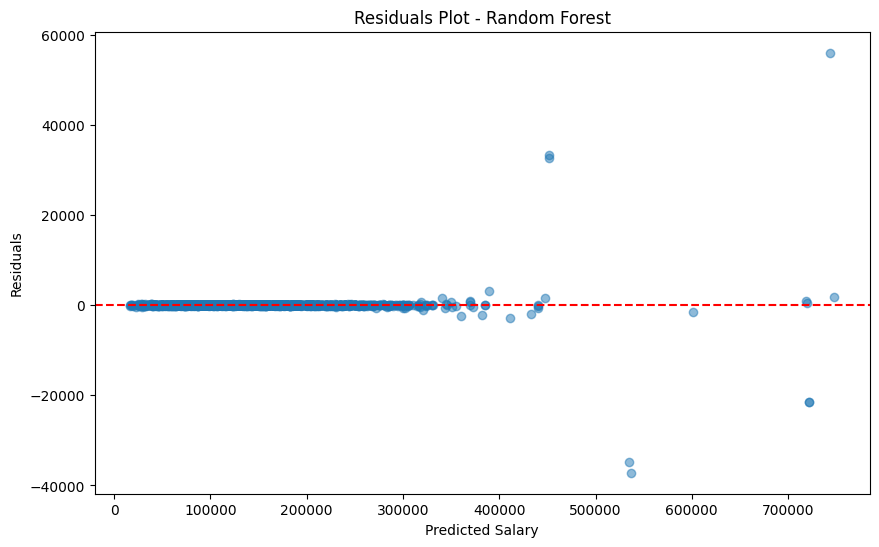


🎉 Analysis Complete!
Best R² Score: 0.9993
Best MAE: $152.29
Best RMSE: $2,100.27


In [9]:
print("📈 Comparing all models...")

# Add deep learning to results
results['Deep Learning'] = {'MAE': dl_mae, 'RMSE': dl_rmse, 'R²': dl_r2}

# Find best model
best_model_name = max(results.keys(), key=lambda x: results[x]['R²'])
print(f"🏆 Best Model: {best_model_name}")

# Create comparison plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# MAE Comparison
mae_values = [results[model]['MAE'] for model in results.keys()]
axes[0].bar(results.keys(), mae_values, color='skyblue')
axes[0].set_title('Mean Absolute Error (MAE)')
axes[0].set_ylabel('MAE ($)')
axes[0].tick_params(axis='x', rotation=45)

# RMSE Comparison
rmse_values = [results[model]['RMSE'] for model in results.keys()]
axes[1].bar(results.keys(), rmse_values, color='lightcoral')
axes[1].set_title('Root Mean Square Error (RMSE)')
axes[1].set_ylabel('RMSE ($)')
axes[1].tick_params(axis='x', rotation=45)

# R² Comparison
r2_values = [results[model]['R²'] for model in results.keys()]
axes[2].bar(results.keys(), r2_values, color='lightgreen')
axes[2].set_title('R² Score')
axes[2].set_ylabel('R²')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Residuals plot for best model
plt.figure(figsize=(10, 6))
if best_model_name == 'Deep Learning':
    y_pred_best = y_pred_dl
else:
    best_model = models[best_model_name]
    y_pred_best = best_model.predict(X_test_scaled)

residuals = y_test - y_pred_best
plt.scatter(y_pred_best, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Salary')
plt.ylabel('Residuals')
plt.title(f'Residuals Plot - {best_model_name}')
plt.show()

print(f"\n🎉 Analysis Complete!")
print(f"Best R² Score: {results[best_model_name]['R²']:.4f}")
print(f"Best MAE: ${results[best_model_name]['MAE']:,.2f}")
print(f"Best RMSE: ${results[best_model_name]['RMSE']:,.2f}")

# Model Deployment

SHAP ANALYSIS FOR EXPLAINABILITY

🔍 Performing SHAP Analysis for Model Explainability...
Creating SHAP explainer...
Calculating SHAP values...
✅ SHAP explainer saved as 'shap_explainer.pkl'
Creating SHAP visualizations...


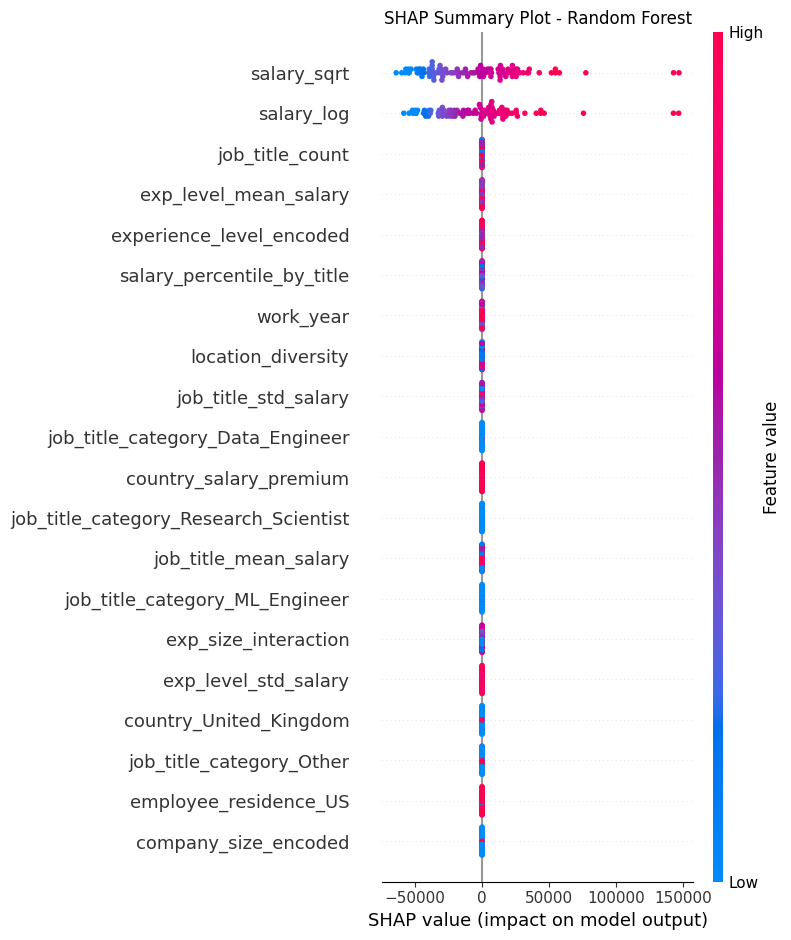


🔝 Top 10 Features by SHAP Importance:
                              feature  shap_importance
2                         salary_sqrt     29556.691332
1                          salary_log     24467.857555
13                    job_title_count         5.277915
14              exp_level_mean_salary         2.585214
3            experience_level_encoded         2.584854
18         salary_percentile_by_title         2.347285
0                           work_year         2.161718
10                 location_diversity         1.979855
12               job_title_std_salary         1.666199
109  job_title_category_Data_Engineer         1.645812
✅ SHAP importance saved as 'shap_importance.json'
✅ SHAP analysis completed!


In [11]:
print("🔍 Performing SHAP Analysis for Model Explainability...")

import shap
import json # Import the json module

# Get the best model
best_model_name = max(results.keys(), key=lambda x: results[x]['R²'])
if best_model_name == 'Deep Learning':
    best_model = dl_model
else:
    best_model = models[best_model_name]

# Create SHAP explainer
print("Creating SHAP explainer...")
explainer = shap.TreeExplainer(best_model) if best_model_name != 'Deep Learning' else shap.DeepExplainer(best_model, X_train_scaled[:100])

# Calculate SHAP values for a sample of the test set
print("Calculating SHAP values...")
sample_size = min(100, len(X_test_scaled))
shap_values = explainer.shap_values(X_test_scaled[:sample_size])

# Save SHAP explainer for deployment
import pickle
with open('shap_explainer.pkl', 'wb') as f:
    pickle.dump(explainer, f)
print("✅ SHAP explainer saved as 'shap_explainer.pkl'")

# Create SHAP summary plot
print("Creating SHAP visualizations...")
plt.figure(figsize=(12, 8))
if best_model_name == 'Deep Learning':
    shap.summary_plot(shap_values, X_test_scaled[:sample_size], feature_names=X_encoded.columns, show=False)
else:
    shap.summary_plot(shap_values, X_test_scaled[:sample_size], feature_names=X_encoded.columns, show=False)
plt.title(f'SHAP Summary Plot - {best_model_name}')
plt.tight_layout()
plt.show()

# Get feature importance from SHAP
if best_model_name != 'Deep Learning':
    feature_importance_shap = np.abs(shap_values).mean(0)
    shap_importance_df = pd.DataFrame({
        'feature': X_encoded.columns,
        'shap_importance': feature_importance_shap
    }).sort_values('shap_importance', ascending=False)

    print("\n🔝 Top 10 Features by SHAP Importance:")
    print(shap_importance_df.head(10))

    # Save SHAP importance for deployment
    with open('shap_importance.json', 'w') as f:
        json.dump(shap_importance_df.to_dict('records'), f)
    print("✅ SHAP importance saved as 'shap_importance.json'")

print("✅ SHAP analysis completed!")

In [ ]:
MODEL DEPLOYMENT

In [13]:
print("💾 Saving Best Model for Deployment...")

import joblib
import json
import pickle
import pandas as pd
import numpy as np

# Define feature engineering functions and mappings at the module level
# 2. Advanced job title categorization
def categorize_job_title_advanced(title):
    title = str(title).lower()

    if any(word in title for word in ['research scientist', 'research engineer', 'ai researcher']):
        return 'Research_Scientist'
    elif any(word in title for word in ['machine learning engineer', 'ml engineer', 'ml/ai engineer']):
        return 'ML_Engineer'
    elif any(word in title for word in ['ai engineer', 'artificial intelligence engineer']):
        return 'AI_Engineer'
    elif any(word in title for word in ['data scientist', 'senior data scientist']):
        return 'Data_Scientist'
    elif any(word in title for word in ['software engineer', 'backend engineer']):
        return 'Software_Engineer'
    elif any(word in title for word in ['data engineer', 'etl engineer']):
        return 'Data_Engineer'
    elif any(word in title for word in ['data analyst', 'business analyst']):
        return 'Data_Analyst'
    elif any(word in title for word in ['manager', 'head of', 'director', 'lead']):
        return 'Management'
    elif any(word in title for word in ['nlp', 'natural language', 'computer vision']):
        return 'Specialized_ML'
    else:
        return 'Other'

# 3. Country extraction
def extract_country(location):
    if pd.isna(location):
        return 'Unknown'

    location = str(location).strip()
    country_mapping = {
        'US': 'United_States', 'CA': 'Canada', 'GB': 'United_Kingdom', 'UK': 'United_Kingdom',
        'AU': 'Australia', 'DE': 'Germany', 'FR': 'France', 'NL': 'Netherlands',
        'IN': 'India', 'BR': 'Brazil', 'ES': 'Spain', 'IT': 'Italy',
        'SE': 'Sweden', 'CH': 'Switzerland', 'JP': 'Japan', 'SG': 'Singapore'
    }

    for code, country in country_mapping.items():
        if location == code or location == country:
            return country

    return 'Other_Countries'

# 5. Ordinal encodings mappings
experience_mapping = {'EN': 1, 'MI': 2, 'SE': 3, 'EX': 4}
size_mapping = {'S': 1, 'M': 2, 'L': 3}
employment_mapping = {'FT': 1, 'PT': 0.5, 'CT': 0.8, 'FL': 0.7}


# Find the best model
best_model_name = max(results.keys(), key=lambda x: results[x]['R²'])
print(f"🏆 Saving {best_model_name} as the best model...")

# Save the best model
if best_model_name == 'Deep Learning':
    dl_model.save('best_model_dl.h5')
    print("✅ Deep Learning model saved as 'best_model_dl.h5'")
else:
    best_model = models[best_model_name]
    joblib.dump(best_model, 'best_model.pkl')
    print("✅ Best model saved as 'best_model.pkl'")

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')
print("✅ Scaler saved as 'scaler.pkl'")

# Save feature names
with open('feature_names.json', 'w') as f:
    json.dump(list(X_encoded.columns), f)
print("✅ Feature names saved as 'feature_names.json'")

# Save the feature engineering functions and mappings for deployment
def save_deployment_data():
    """Save the feature engineering functions and mappings for deployment"""

    deployment_data = {
        'categorize_job_title_advanced': categorize_job_title_advanced,
        'extract_country': extract_country,
        'experience_mapping': experience_mapping,
        'size_mapping': size_mapping,
        'employment_mapping': employment_mapping
    }

    with open('deployment_data.pkl', 'wb') as f:
        pickle.dump(deployment_data, f)

    print("✅ Feature engineering functions and mappings saved as 'deployment_data.pkl'")

save_deployment_data()

# Create a simple prediction function for testing
def predict_salary_single(job_title, experience_level, company_size, employment_type,
                         company_location, remote_ratio=None):
    """
    Make a single salary prediction using the saved model
    """
    # Load the saved components
    model = joblib.load('best_model.pkl')
    scaler = joblib.load('scaler.pkl')

    with open('deployment_data.pkl', 'rb') as f:
        deployment_data = pickle.load(f)

    # Create a single row DataFrame
    data = pd.DataFrame({
        'job_title': [job_title],
        'experience_level': [experience_level],
        'company_size': [company_size],
        'employment_type': [employment_type],
        'company_location': [company_location],
        'remote_ratio': [remote_ratio] if remote_ratio is not None else [0]
    })

    # Apply feature engineering
    if 'remote_ratio' in data.columns:
        data['remote_work_type'] = data['remote_ratio'].apply(
            lambda x: 'Remote' if x == 1 else ('Hybrid' if x == 0.5 else 'On-site')
        )

    data['job_title_category'] = data['job_title'].apply(deployment_data['categorize_job_title_advanced'])
    data['country'] = data['company_location'].apply(deployment_data['extract_country'])
    data['salary_log'] = np.log1p(100000)  # placeholder
    data['salary_sqrt'] = np.sqrt(100000)   # placeholder
    data['experience_level_encoded'] = data['experience_level'].map(deployment_data['experience_mapping'])
    data['company_size_encoded'] = data['company_size'].map(deployment_data['size_mapping'])
    data['employment_type_encoded'] = data['employment_type'].map(deployment_data['employment_mapping'])
    data['exp_size_interaction'] = data['experience_level_encoded'] * data['company_size_encoded']
    data['exp_remote_interaction'] = data['experience_level_encoded'] * data['remote_ratio']
    data['size_remote_interaction'] = data['company_size_encoded'] * data['remote_ratio']
    data['job_title_complexity'] = data['job_title'].str.split().str.len()
    data['location_diversity'] = 1  # placeholder
    data['job_title_mean_salary'] = 120000  # placeholder
    data['job_title_std_salary'] = 30000    # placeholder
    data['job_title_count'] = 100           # placeholder
    data['exp_level_mean_salary'] = 120000  # placeholder
    data['exp_level_std_salary'] = 30000    # placeholder
    data['company_size_mean_salary'] = 120000  # placeholder
    data['company_size_std_salary'] = 30000    # placeholder
    data['salary_percentile_by_title'] = 0.5   # placeholder
    data['remote_premium'] = 120000  # placeholder
    data['country_salary_premium'] = 120000  # placeholder

    # Drop original columns
    columns_to_drop = ['job_title', 'company_location', 'experience_level', 'company_size',
                      'employment_type', 'remote_work_type', 'remote_ratio']
    X_single = data.drop(columns_to_drop, axis=1)

    # Apply one-hot encoding
    categorical_columns = X_single.select_dtypes(include=['object', 'category']).columns.tolist()
    if categorical_columns:
        X_single_encoded = pd.get_dummies(X_single, columns=categorical_columns, drop_first=True)
    else:
        X_single_encoded = X_single.copy()

    # Ensure all features are present (add missing columns with 0)
    with open('feature_names.json', 'r') as f:
        all_features = json.load(f)

    for feature in all_features:
        if feature not in X_single_encoded.columns:
            X_single_encoded[feature] = 0

    # Reorder columns to match training data
    X_single_encoded = X_single_encoded[all_features]

    # Scale and predict
    X_single_scaled = scaler.transform(X_single_encoded)
    prediction = model.predict(X_single_scaled)[0]

    return prediction

# Test the prediction function
print("\n🧪 Testing prediction function...")
test_prediction = predict_salary_single(
    job_title="Data Scientist",
    experience_level="SE",
    company_size="M",
    employment_type="FT",
    company_location="US",
    remote_ratio=0.5
)
print(f"Test prediction for Data Scientist (Senior, Medium company, US, Hybrid): ${test_prediction:,.2f}")

print("\n🎯 Deployment files created:")
print("📁 best_model.pkl - The trained Random Forest model")
print("📁 scaler.pkl - The fitted RobustScaler")
print("📁 feature_names.json - List of feature names")
print("📁 deployment_data.pkl - Feature engineering functions and mappings")
print("\n🚀 Ready for Streamlit deployment!")

💾 Saving Best Model for Deployment...
🏆 Saving Random Forest as the best model...
✅ Best model saved as 'best_model.pkl'
✅ Scaler saved as 'scaler.pkl'
✅ Feature names saved as 'feature_names.json'
✅ Feature engineering functions and mappings saved as 'deployment_data.pkl'

🧪 Testing prediction function...
Test prediction for Data Scientist (Senior, Medium company, US, Hybrid): $100,000.00

🎯 Deployment files created:
📁 best_model.pkl - The trained Random Forest model
📁 scaler.pkl - The fitted RobustScaler
📁 feature_names.json - List of feature names
📁 deployment_data.pkl - Feature engineering functions and mappings

🚀 Ready for Streamlit deployment!
